# Quantitative Finance

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels yfinance

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize
import itertools
import time

# Technical Analysis & Financial Metrics with fallback handling
try:
    import talib as ta
    TALIB_AVAILABLE = True
    print("TA-Lib available - using advanced technical indicators")
except ImportError:
    print("TA-Lib not available - using simplified technical indicators")
    TALIB_AVAILABLE = False
    
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Statistical Analysis
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

# Visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


TA-Lib available - using advanced technical indicators


# Sourcing Data

In [3]:
class DataManager:
    """Enhanced data management with comprehensive error handling and fallbacks."""

    def __init__(self):
        self.cache = {}
        self.failed_tickers = []

    def download_stock_data(self, tickers, start_date="2022-01-01", end_date=None, max_retries=3):
        """Download stock data with enhanced error handling, retries, and caching."""
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        print(f"Downloading data for {len(tickers)} tickers from {start_date} to {end_date}...")
        successful_data = {}
        failed_tickers = []

        for i, ticker in enumerate(tickers):
            print(f"Processing {ticker} ({i+1}/{len(tickers)})...", end=" ")
            retry_count = 0
            
            while retry_count < max_retries:
                try:
                    # Download with timeout and error handling
                    data = yf.download(
                        ticker,
                        start=start_date,
                        end=end_date,
                        auto_adjust=True,
                        progress=False,
                        timeout=10,
                        threads=False  # Avoid threading issues
                    )

                    if data.empty:
                        print(f"No data returned for {ticker}")
                        retry_count += 1
                        continue
                    
                    if len(data) < 50:
                        print(f"Insufficient data points ({len(data)}) for {ticker}")
                        retry_count += 1
                        continue

                    # Basic data validation
                    if self._validate_data_quality(data, ticker):
                        data = self._clean_data(data)
                        if not data.empty:
                            successful_data[ticker] = data
                            print(f"Success - {len(data)} points")
                            break
                        else:
                            print(f"Data became empty after cleaning")
                            retry_count += 1
                    else:
                        print(f"Failed validation")
                        retry_count += 1

                except Exception as e:
                    print(f"Error: {str(e)[:50]}...")
                    retry_count += 1
                    
                if retry_count >= max_retries:
                    print(f"Failed after {max_retries} attempts")
                    failed_tickers.append(ticker)
                    break
                    
                # Brief pause between retries
                time.sleep(0.5)

        self.failed_tickers.extend(failed_tickers)

        print(f"\nSuccessfully downloaded: {len(successful_data)} tickers")
        if failed_tickers:
            print(f"Failed: {len(failed_tickers)} tickers")
            print(f"Failed tickers: {failed_tickers}")
            
        # If too many failures, try fallback approach
        if len(successful_data) < 5:
            print("Too few successful downloads, trying fallback stocks...")
            fallback_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
            fallback_data = self._download_fallback(fallback_tickers, start_date, end_date)
            successful_data.update(fallback_data)
            
        return successful_data

    def _download_fallback(self, tickers, start_date, end_date):
        """Download fallback data for highly liquid stocks."""
        fallback_data = {}
        for ticker in tickers:
            if ticker not in self.failed_tickers:
                try:
                    data = yf.download(ticker, start=start_date, end=end_date, 
                                     auto_adjust=True, progress=False)
                    if not data.empty and len(data) >= 50:
                        if isinstance(data.columns, pd.MultiIndex):
                            data.columns = [col[0] for col in data.columns]
                        data = self._clean_data(data)
                        if not data.empty:
                            fallback_data[ticker] = data
                            print(f"Fallback success: {ticker}")
                except Exception as e:
                    print(f"Fallback failed for {ticker}: {e}")
        return fallback_data

    @staticmethod
    def _get_column_series(data, col_name):
        """Safely extract a column as a Series even if MultiIndex columns exist."""
        if col_name not in data.columns:
            return pd.Series(dtype='float64')
        series = data[col_name]
        if isinstance(series, pd.DataFrame):
            # Pick the first column if MultiIndex
            series = series.iloc[:, 0]
        return series

    def _validate_data_quality(self, data, ticker):
        """Validate data quality with robust checks and debug output."""
        try:
            # 1. Minimum length
            if len(data) < 50:
                return False

            # 2. Handle MultiIndex columns from yfinance
            if isinstance(data.columns, pd.MultiIndex):
                data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

            # 3. Required columns
            required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
            available_cols = data.columns.tolist()
            
            if not all(col in available_cols for col in required_cols):
                print(f"Missing columns for {ticker}. Available: {available_cols}")
                return False

            # 4. Extract Close prices as Series and validate
            close_prices = self._get_column_series(data, 'Close').dropna()
            if close_prices.empty:
                return False

            # 5. Non-negative prices
            if (close_prices <= 0).any():
                return False

            # 6. Missing values check
            missing_pct = data[required_cols].isnull().sum().max() / len(data)
            if missing_pct > 0.2:
                return False

            return True

        except Exception as e:
            print(f"Validation error for {ticker}: {e}")
            return False

    def _clean_data(self, data):
        """Enhanced data cleaning with comprehensive error handling."""
        # Flatten MultiIndex columns if they exist
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

        # Forward fill and drop remaining NaNs
        data = data.fillna(method='ffill').dropna()

        # Ensure we have the required columns
        required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in required_cols:
            if col not in data.columns:
                print(f"Missing required column: {col}")
                return pd.DataFrame()  # Return empty DataFrame

        # Compute returns with proper error handling
        close = self._get_column_series(data, 'Close')
        if close.empty:
            print("No Close price data available")
            return pd.DataFrame()

        returns = {'1M': 21, '3M': 63, '6M': 126}
        
        for label, days in returns.items():
            if len(close) > days:
                data[f'Return_{label}'] = close.pct_change(periods=days)
            else:
                # If not enough data, fill with NaN
                data[f'Return_{label}'] = np.nan
                print(f"Not enough data for {label} return calculation (need {days}, have {len(close)})")

        # Don't drop rows where returns are NaN - we'll handle this in screening
        return data
   

# Technical indicators

In [4]:
class TechnicalIndicators:
    """
    Comprehensive technical indicators library with robust fallback implementations.
    """
    
    @staticmethod
    def _simple_rsi(prices, period=14):
        """Simple RSI implementation when TA-Lib is not available."""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    @staticmethod
    def _simple_macd(prices, fast=12, slow=26, signal=9):
        """Simple MACD implementation when TA-Lib is not available."""
        ema_fast = prices.ewm(span=fast).mean()
        ema_slow = prices.ewm(span=slow).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal).mean()
        histogram = macd_line - signal_line
        return macd_line, signal_line, histogram
    
    @staticmethod
    def _simple_bollinger_bands(prices, period=20, std_dev=2):
        """Simple Bollinger Bands implementation when TA-Lib is not available."""
        sma = prices.rolling(window=period).mean()
        rolling_std = prices.rolling(window=period).std()
        upper_band = sma + (rolling_std * std_dev)
        lower_band = sma - (rolling_std * std_dev)
        return upper_band, sma, lower_band
    
    @staticmethod
    def _simple_stoch(high, low, close, k_period=14, d_period=3):
        """Simple Stochastic implementation."""
        lowest_low = low.rolling(window=k_period).min()
        highest_high = high.rolling(window=k_period).max()
        k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
        d_percent = k_percent.rolling(window=d_period).mean()
        return k_percent, d_percent
    
    @staticmethod
    def add_all_indicators(data):
        """Add comprehensive set of technical indicators with robust error handling."""
        df = data.copy()
        
        # Ensure we have numeric data and handle MultiIndex columns
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
        
        # Convert to numeric and handle any data type issues
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Remove any rows with NaN in key columns
        df = df.dropna(subset=['Close'])
        
        if len(df) < 20:  # Need minimum data for indicators
            print("Warning: Insufficient data for technical indicators")
            return df
        
        try:
            # Price-based features
            df['Returns'] = df['Close'].pct_change()
            df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
            df['Price_Change'] = df['Close'] - df['Open']
            df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Close']
            
            # Moving Averages (Trend Indicators)
            for period in [5, 10, 20, 50, 200]:
                if len(df) >= period:
                    df[f'SMA_{period}'] = df['Close'].rolling(window=period).mean()
                    df[f'EMA_{period}'] = df['Close'].ewm(span=period).mean()
            
            # Price position relative to moving averages
            if 'SMA_20' in df.columns:
                df['Price_vs_SMA20'] = df['Close'] / df['SMA_20'] - 1
            if 'SMA_50' in df.columns:
                df['Price_vs_SMA50'] = df['Close'] / df['SMA_50'] - 1
            if 'SMA_20' in df.columns and 'SMA_50' in df.columns:
                df['SMA20_vs_SMA50'] = df['SMA_20'] / df['SMA_50'] - 1
            
            # Bollinger Bands (Volatility) - with error handling
            try:
                if TALIB_AVAILABLE and len(df) >= 20:
                    close_values = df['Close'].values.astype(np.float64)
                    bb_result = ta.BBANDS(close_values, timeperiod=20)
                    df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = bb_result
                else:
                    df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = TechnicalIndicators._simple_bollinger_bands(df['Close'])
                
                if 'BB_Upper' in df.columns and 'BB_Lower' in df.columns:
                    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']
                    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
            except Exception as e:
                print(f"Warning: Could not calculate Bollinger Bands: {e}")
            
            # RSI (Momentum) - with error handling
            for period in [14, 30]:
                try:
                    if len(df) >= period + 10:
                        if TALIB_AVAILABLE:
                            close_values = df['Close'].values.astype(np.float64)
                            rsi_values = ta.RSI(close_values, timeperiod=period)
                            df[f'RSI_{period}'] = rsi_values
                        else:
                            df[f'RSI_{period}'] = TechnicalIndicators._simple_rsi(df['Close'], period)
                except Exception as e:
                    print(f"Warning: Could not calculate RSI_{period}: {e}")
            
            # MACD (Trend/Momentum) - with error handling
            try:
                if TALIB_AVAILABLE and len(df) >= 35:
                    close_values = df['Close'].values.astype(np.float64)
                    macd_result = ta.MACD(close_values)
                    df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = macd_result
                else:
                    df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = TechnicalIndicators._simple_macd(df['Close'])
            except Exception as e:
                print(f"Warning: Could not calculate MACD: {e}")
            
            # Stochastic Oscillator - with error handling
            try:
                if TALIB_AVAILABLE and len(df) >= 20:
                    high_values = df['High'].values.astype(np.float64)
                    low_values = df['Low'].values.astype(np.float64)
                    close_values = df['Close'].values.astype(np.float64)
                    df['Stoch_K'], df['Stoch_D'] = ta.STOCH(high_values, low_values, close_values)
                else:
                    df['Stoch_K'], df['Stoch_D'] = TechnicalIndicators._simple_stoch(df['High'], df['Low'], df['Close'])
            except Exception as e:
                print(f"Warning: Could not calculate Stochastic: {e}")
            
            # Volume Indicators
            if 'Volume' in df.columns:
                df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
                df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']
                
                # On-Balance Volume - simplified implementation
                try:
                    if TALIB_AVAILABLE:
                        volume_values = df['Volume'].values.astype(np.float64)
                        close_values = df['Close'].values.astype(np.float64)
                        obv_values = ta.OBV(close_values, volume_values)
                        df['OBV'] = obv_values
                    else:
                        # Simple OBV implementation
                        price_changes = df['Close'].diff()
                        volume_direction = np.where(price_changes > 0, df['Volume'], 
                                                   np.where(price_changes < 0, -df['Volume'], 0))
                        df['OBV'] = volume_direction.cumsum()
                except Exception as e:
                    print(f"Warning: Could not calculate OBV: {e}")
            
            # Price Rate of Change
            for period in [10, 20]:
                try:
                    if len(df) >= period + 10:
                        if TALIB_AVAILABLE:
                            close_values = df['Close'].values.astype(np.float64)
                            roc_values = ta.ROC(close_values, timeperiod=period)
                            df[f'ROC_{period}'] = roc_values
                        else:
                            df[f'ROC_{period}'] = df['Close'].pct_change(periods=period) * 100
                except Exception as e:
                    print(f"Warning: Could not calculate ROC_{period}: {e}")
            
            # Average True Range (Volatility) - with fallback
            try:
                if TALIB_AVAILABLE:
                    high_values = df['High'].values.astype(np.float64)
                    low_values = df['Low'].values.astype(np.float64)
                    close_values = df['Close'].values.astype(np.float64)
                    df['ATR'] = ta.ATR(high_values, low_values, close_values)
                else:
                    # Simple ATR calculation
                    tr1 = df['High'] - df['Low']
                    tr2 = abs(df['High'] - df['Close'].shift(1))
                    tr3 = abs(df['Low'] - df['Close'].shift(1))
                    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
                    df['ATR'] = true_range.rolling(window=14).mean()
                
                if 'ATR' in df.columns:
                    df['ATR_Pct'] = df['ATR'] / df['Close']
            except Exception as e:
                print(f"Warning: Could not calculate ATR: {e}")
            
            # Volatility measures
            if len(df) >= 20:
                df['Volatility_20'] = df['Returns'].rolling(window=20).std() * np.sqrt(252)
            
            # Support and Resistance levels
            if len(df) >= 20:
                df['Support'] = df['Low'].rolling(window=20).min()
                df['Resistance'] = df['High'].rolling(window=20).max()
                df['Support_Distance'] = (df['Close'] - df['Support']) / df['Close']
                df['Resistance_Distance'] = (df['Resistance'] - df['Close']) / df['Close']
            
        except Exception as e:
            print(f"Warning: Error in technical indicators calculation: {e}")
        
        return df


# Stock screening

In [5]:
class StockScreener:
    """
    Professional stock screening system with comprehensive error handling.
    """
    
    def __init__(self, data_manager):
        self.data_manager = data_manager
        self.universe = self._get_stock_universe()
        
    def _get_stock_universe(self):
        """Define investable universe with fallback options."""
        # S&P 500 core holdings + high-volume tech stocks
        primary_universe = [
            'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'META', 'NVDA', 'BRK-B',
            'UNH', 'JNJ', 'XOM', 'JPM', 'V', 'PG', 'MA', 'HD', 'CVX', 'ABBV',
            'LLY', 'BAC', 'AVGO', 'KO', 'PEP', 'TMO', 'COST', 'WMT', 'MRK',
            'DHR', 'VZ', 'ACN', 'ABT', 'ADBE', 'CRM', 'NFLX', 'ORCL', 'NKE',
            'AMD', 'QCOM', 'TXN', 'HON', 'RTX', 'UPS', 'LOW', 'SPGI', 'AMGN',
            'INTC', 'IBM', 'CAT', 'GS', 'BKNG', 'GILD', 'AXP', 'BLK', 'MDLZ',
            'T', 'DE', 'SYK', 'TMUS', 'ADP', 'TJX', 'CVS', 'VRTX', 'SCHW',
        ]
        
        return primary_universe[:30]  # Limit to 30 for faster processing
        
    def screen_stocks(self, lookback_days=630):
        """Screen stocks based on multiple criteria with robust error handling."""
        print("Screening stock universe...")
        
        # Download data for universe
        end_date = datetime.now()
        start_date = end_date - timedelta(days=lookback_days + 100)
        
        stock_data = self.data_manager.download_stock_data(
            self.universe, start_date.strftime('%Y-%m-%d'))
        
        screen_results = []
        
        for ticker, data in stock_data.items():
            try:
                # Add technical indicators
                data_with_indicators = TechnicalIndicators.add_all_indicators(data)
                recent_data = data_with_indicators.tail(lookback_days)
                
                # Calculate screening metrics
                metrics = self._calculate_screening_metrics(recent_data, ticker)
                if metrics:  # Only add if metrics were calculated successfully
                    screen_results.append(metrics)
                
            except Exception as e:
                print(f"Error screening {ticker}: {str(e)}")
                continue
        
        # Convert to DataFrame and rank
        if not screen_results:
            print("No stocks successfully screened")
            return pd.DataFrame(), stock_data
            
        df_results = pd.DataFrame(screen_results)
        df_ranked = self._rank_stocks(df_results)
        
        print(f"Screened {len(df_ranked)} stocks successfully")
        return df_ranked, stock_data
    
    def _calculate_screening_metrics(self, data, ticker):
        """Calculate comprehensive screening metrics with robust error handling."""
        try:
            n_rows = len(data)
            if n_rows < 50:
                return None
                
            latest = data.iloc[-1]

            def safe_return(period_name):
                """Safely calculate returns, handling missing data."""
                if f'Return_{period_name}' in data.columns:
                    return_series = data[f'Return_{period_name}'].dropna()
                    if not return_series.empty:
                        return return_series.iloc[-1] * 100
                return np.nan

            def safe_return_manual(period):
                """Manual return calculation as fallback."""
                if n_rows > period:
                    try:
                        return (data['Close'].iloc[-1] / data['Close'].iloc[-period-1] - 1) * 100
                    except:
                        return np.nan
                return np.nan

            # Ensure returns exist
            if 'Returns' not in data.columns:
                data['Returns'] = data['Close'].pct_change()

            # Try to get returns from pre-calculated columns, fallback to manual calculation
            return_1m = safe_return('1M')
            if pd.isna(return_1m):
                return_1m = safe_return_manual(22)
                
            return_3m = safe_return('3M')
            if pd.isna(return_3m):
                return_3m = safe_return_manual(66)
                
            return_6m = safe_return('6M')
            if pd.isna(return_6m):
                return_6m = safe_return_manual(126)
                
            return_1y = safe_return_manual(252)

            metrics = {
                'Ticker': ticker,
                'Price': latest['Close'],
                'Market_Cap_Proxy': latest['Close'] * latest['Volume'],  # Rough proxy
                
                # Performance Metrics
                'Return_1M': return_1m,
                'Return_3M': return_3m,
                'Return_6M': return_6m,
                'Return_1Y': return_1y,
                
                # Risk Metrics
                'Volatility': data['Returns'].std() * np.sqrt(252) * 100,
                'Max_Drawdown': self._calculate_max_drawdown(data['Close']),
                'Sharpe_Ratio': self._calculate_sharpe_ratio(data['Returns']),
                
                # Technical Metrics (with safe defaults)
                'RSI': latest.get('RSI_14', 50),  # Default to neutral
                'Price_vs_SMA20': latest.get('Price_vs_SMA20', 0) * 100,
                'Price_vs_SMA50': latest.get('Price_vs_SMA50', 0) * 100,
                'BB_Position': latest.get('BB_Position', 0.5),  # Default to middle
                'Volume_Ratio': latest.get('Volume_Ratio', 1.0),  # Default to average
                
                # Momentum Metrics
                'ROC_20': latest.get('ROC_20', 0),  # Default to no change
                'MACD_Signal': 1 if latest.get('MACD', 0) > latest.get('MACD_Signal', 0) else 0,
                
                # Quality Metrics
                'Price_Stability': 1 / (data['Returns'].std() + 1e-6),
                'Trend_Strength': abs(data['Close'].iloc[-1] / data['Close'].iloc[-50] - 1) if n_rows > 50 else 0,
            }
            
            return metrics
            
        except Exception as e:
            print(f"Error calculating metrics for {ticker}: {e}")
            return None
    
    def _calculate_max_drawdown(self, prices):
        """Calculate maximum drawdown."""
        peak = prices.expanding().max()
        drawdown = (prices - peak) / peak
        return drawdown.min() * 100
    
    def _calculate_sharpe_ratio(self, returns, risk_free_rate=0.02):
        """Calculate Sharpe ratio."""
        excess_returns = returns.mean() * 252 - risk_free_rate
        volatility = returns.std() * np.sqrt(252)
        return excess_returns / volatility if volatility > 0 else 0
    
    def _rank_stocks(self, df):
        """Create composite ranking system with robust handling of missing data."""
        if df.empty:
            return df
            
        # Fill NaN values with median before ranking
        numeric_columns = ['Return_3M', 'Volatility', 'ROC_20', 'Price_vs_SMA20']
        
        for col in numeric_columns:
            if col in df.columns:
                # Fill NaN with median, or 0 if all NaN
                median_val = df[col].median()
                if pd.isna(median_val):
                    median_val = 0
                df[col] = df[col].fillna(median_val)
        
        # Normalize metrics (higher is better)
        if 'Return_3M' in df.columns and not df['Return_3M'].isnull().all():
            df['Return_Score'] = stats.rankdata(df['Return_3M']) / len(df)
        else:
            df['Return_Score'] = 0.5  # Neutral score
            
        if 'Volatility' in df.columns and not df['Volatility'].isnull().all():
            df['Quality_Score'] = stats.rankdata(-df['Volatility']) / len(df)  # Lower vol is better
        else:
            df['Quality_Score'] = 0.5
            
        if 'ROC_20' in df.columns and not df['ROC_20'].isnull().all():
            df['Momentum_Score'] = stats.rankdata(df['ROC_20']) / len(df)
        else:
            df['Momentum_Score'] = 0.5
            
        if 'Price_vs_SMA20' in df.columns and not df['Price_vs_SMA20'].isnull().all():
            df['Technical_Score'] = stats.rankdata(df['Price_vs_SMA20']) / len(df)
        else:
            df['Technical_Score'] = 0.5
        
        # Composite score
        df['Composite_Score'] = (
            df['Return_Score'] * 0.3 +
            df['Quality_Score'] * 0.25 +
            df['Momentum_Score'] * 0.25 +
            df['Technical_Score'] * 0.2
        )
        
        return df.sort_values('Composite_Score', ascending=False)


# Strategies

In [6]:
class TradingStrategies:
    """
    Comprehensive trading strategy library with error handling.
    """
    
    def __init__(self):
        self.strategies = {}
        
    # ------------------------------------------------------------------------
    # SIMPLE STRATEGIES
    # ------------------------------------------------------------------------
    
    def moving_average_crossover(self, data, short_window=20, long_window=50, 
                               initial_capital=100000, transaction_cost=0.001):
        """
        Simple Moving Average Crossover Strategy
        
        Logic: Buy when short MA crosses above long MA, sell when opposite.
        This is a classic trend-following strategy used by many professionals.
        """
        df = data.copy()
        
        # Generate signals
        df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
        df['Long_MA'] = df['Close'].rolling(window=long_window).mean()
        
        # Signal generation
        df['Signal'] = 0
        df['Signal'][short_window:] = np.where(
            df['Short_MA'][short_window:] > df['Long_MA'][short_window:], 1, 0)
        
        df['Position'] = df['Signal'].diff()
        
        # Calculate returns with transaction costs
        df['Strategy_Returns'] = df['Signal'].shift(1) * df['Close'].pct_change()
        
        # Apply transaction costs
        df['Trades'] = df['Position'].abs()
        df['Transaction_Costs'] = df['Trades'] * transaction_cost
        df['Strategy_Returns_Net'] = df['Strategy_Returns'] - df['Transaction_Costs']
        
        # Portfolio value
        df['Portfolio_Value'] = initial_capital * (1 + df['Strategy_Returns_Net']).cumprod()
        
        return df
    
    def rsi_mean_reversion(self, data, rsi_period=14, oversold=30, overbought=70,
                          initial_capital=100000, transaction_cost=0.001):
        """
        RSI Mean Reversion Strategy
        
        Logic: Buy when RSI < oversold, sell when RSI > overbought.
        This contrarian strategy works well in ranging markets.
        """
        df = data.copy()
        df = TechnicalIndicators.add_all_indicators(df)
        
        # Generate signals
        df['Signal'] = 0
        df['Signal'] = np.where(df[f'RSI_{rsi_period}'] < oversold, 1,
                               np.where(df[f'RSI_{rsi_period}'] > overbought, -1, 0))
        
        # Forward fill signals (hold position until new signal)
        df['Position'] = df['Signal'].replace(0, np.nan).fillna(method='ffill').fillna(0)
        df['Position_Change'] = df['Position'].diff().abs()
        
        # Calculate returns
        df['Strategy_Returns'] = df['Position'].shift(1) * df['Close'].pct_change()
        df['Transaction_Costs'] = df['Position_Change'] * transaction_cost
        df['Strategy_Returns_Net'] = df['Strategy_Returns'] - df['Transaction_Costs']
        df['Portfolio_Value'] = initial_capital * (1 + df['Strategy_Returns_Net']).cumprod()
        
        return df
    
    # ------------------------------------------------------------------------
    # INTERMEDIATE STRATEGIES
    # ------------------------------------------------------------------------
    
    def bollinger_bands_strategy(self, data, bb_period=20, bb_std=2,
                                initial_capital=100000, transaction_cost=0.001):
        """
        Bollinger Bands Strategy
        
        Professional mean-reversion strategy using volatility bands.
        Buy when price touches lower band, sell when touching upper band.
        """
        df = data.copy()
        df = TechnicalIndicators.add_all_indicators(df)
        
        # Enhanced signal generation
        df['Signal'] = 0
        df['Lower_Touch'] = df['Close'] <= df['BB_Lower'] * 1.01  # Small buffer
        df['Upper_Touch'] = df['Close'] >= df['BB_Upper'] * 0.99
        df['Middle_Cross'] = df['Close'].shift(1) < df['BB_Middle']
        
        # Multi-condition signals
        buy_condition = df['Lower_Touch'] & (df['RSI_14'] < 40)
        sell_condition = df['Upper_Touch'] | (df['RSI_14'] > 70)
        
        df['Signal'] = np.where(buy_condition, 1,
                               np.where(sell_condition, -1, 0))
        
        df['Position'] = df['Signal'].replace(0, np.nan).fillna(method='ffill').fillna(0)
        df['Position_Change'] = df['Position'].diff().abs()
        
        # Risk management: No position if volatility too high
        if 'BB_Width' in df.columns:
            high_volatility = df['BB_Width'] > df['BB_Width'].rolling(50).quantile(0.8)
            df['Position'] = np.where(high_volatility, 0, df['Position'])
        
        # Calculate returns
        df['Strategy_Returns'] = df['Position'].shift(1) * df['Close'].pct_change()
        df['Transaction_Costs'] = df['Position_Change'] * transaction_cost
        df['Strategy_Returns_Net'] = df['Strategy_Returns'] - df['Transaction_Costs']
        df['Portfolio_Value'] = initial_capital * (1 + df['Strategy_Returns_Net']).cumprod()
        
        return df
    
    def momentum_strategy(self, data, lookback_period=20, holding_period=5,
                         initial_capital=100000, transaction_cost=0.001):
        """
        Momentum Strategy
        
        Professional momentum strategy: Buy stocks with strong recent performance,
        hold for fixed period. Widely used by institutional investors.
        """
        df = data.copy()
        df = TechnicalIndicators.add_all_indicators(df)
        
        # Calculate momentum score
        roc_col = f'ROC_{lookback_period}' if f'ROC_{lookback_period}' in df.columns else 'Returns'
        price_vs_sma = 'Price_vs_SMA20' if 'Price_vs_SMA20' in df.columns else 'Returns'
        volume_ratio = 'Volume_Ratio' if 'Volume_Ratio' in df.columns else 'Returns'
        
        df['Momentum_Score'] = (
            df[roc_col].fillna(0) * 0.4 +
            df[price_vs_sma].fillna(0) * 100 * 0.3 +
            df[volume_ratio].fillna(1) * 0.3
        )
        
        # Rank-based signals
        df['Momentum_Rank'] = df['Momentum_Score'].rolling(252).rank(pct=True)
        
        # Generate signals: Buy top 20%, sell bottom 20%
        df['Signal'] = np.where(df['Momentum_Rank'] > 0.8, 1,
                               np.where(df['Momentum_Rank'] < 0.2, -1, 0))
        
        # Hold positions for specified period
        df['Position'] = 0
        signal_changes = df[df['Signal'] != 0].index
        
        for i, idx in enumerate(signal_changes):
            signal_value = df.loc[idx, 'Signal']
            end_idx = min(len(df) - 1, 
                         df.index.get_loc(idx) + holding_period)
            df.loc[idx:df.index[end_idx], 'Position'] = signal_value
        
        df['Position_Change'] = df['Position'].diff().abs()
        
        # Calculate returns
        df['Strategy_Returns'] = df['Position'].shift(1) * df['Close'].pct_change()
        df['Transaction_Costs'] = df['Position_Change'] * transaction_cost
        df['Strategy_Returns_Net'] = df['Strategy_Returns'] - df['Transaction_Costs']
        df['Portfolio_Value'] = initial_capital * (1 + df['Strategy_Returns_Net']).cumprod()
        
        return df
    
    # ------------------------------------------------------------------------
    # ADVANCED STRATEGIES
    # ------------------------------------------------------------------------
    
    def multi_factor_strategy(self, data, initial_capital=100000, transaction_cost=0.001):
        """
        Multi-Factor Strategy
        
        Professional quant strategy combining multiple factors:
        - Momentum (price trends)
        - Mean reversion (oversold/overbought)
        - Volume (institutional interest)
        - Volatility (risk adjustment)
        """
        df = data.copy()
        df = TechnicalIndicators.add_all_indicators(df)
        
        # Factor 1: Momentum
        momentum_signals = []
        if 'ROC_20' in df.columns:
            momentum_signals.append((df['ROC_20'] > 0).astype(int) * 0.3)
        if 'Price_vs_SMA20' in df.columns:
            momentum_signals.append((df['Price_vs_SMA20'] > 0.02).astype(int) * 0.2)
        if 'MACD' in df.columns and 'MACD_Signal' in df.columns:
            momentum_signals.append((df['MACD'] > df['MACD_Signal']).astype(int) * 0.3)
        if 'EMA_10' in df.columns:
            momentum_signals.append((df['Close'] > df['EMA_10']).astype(int) * 0.2)
        
        if momentum_signals:
            df['Momentum_Factor'] = sum(momentum_signals)
        else:
            df['Momentum_Factor'] = 0.5
        
        # Factor 2: Mean Reversion
        meanrev_signals = []
        if 'RSI_14' in df.columns:
            meanrev_signals.append((df['RSI_14'] < 35).astype(int) * 0.4)
        if 'BB_Position' in df.columns:
            meanrev_signals.append((df['BB_Position'] < 0.2).astype(int) * 0.3)
        
        # Add Williams %R if available
        if 'Stoch_K' in df.columns:  # Use Stochastic as proxy for Williams %R
            meanrev_signals.append((df['Stoch_K'] < 20).astype(int) * 0.3)
        
        if meanrev_signals:
            df['MeanRev_Factor'] = sum(meanrev_signals)
        else:
            df['MeanRev_Factor'] = 0.25
        
        # Factor 3: Volume
        if 'Volume_Ratio' in df.columns:
            df['Volume_Factor'] = (
                (df['Volume_Ratio'] > 1.2).astype(int) * 0.5 +
                (df['Volume_Ratio'] < 2.5).astype(int) * 0.5
            )
        else:
            df['Volume_Factor'] = 0.5
        
        # Factor 4: Volatility (risk)
        if 'Volatility_20' in df.columns:
            volatility_percentile = df['Volatility_20'].rolling(252).rank(pct=True)
            df['Vol_Factor'] = (volatility_percentile < 0.7).astype(int)
        else:
            df['Vol_Factor'] = 0.7
        
        # Composite signal
        df['Composite_Score'] = (
            df['Momentum_Factor'] * 0.35 +
            df['MeanRev_Factor'] * 0.25 +
            df['Volume_Factor'] * 0.2 +
            df['Vol_Factor'] * 0.2
        )
        
        # Generate signals based on composite score
        df['Signal'] = np.where(df['Composite_Score'] >= 0.6, 1,
                               np.where(df['Composite_Score'] <= 0.3, -1, 0))
        
        # Position sizing based on confidence
        df['Position_Size'] = df['Composite_Score']
        df['Position'] = df['Signal'] * df['Position_Size']
        df['Position'] = df['Position'].clip(-1, 1)
        
        df['Position_Change'] = df['Position'].diff().abs()
        
        # Calculate returns
        df['Strategy_Returns'] = df['Position'].shift(1) * df['Close'].pct_change()
        df['Transaction_Costs'] = df['Position_Change'] * transaction_cost
        df['Strategy_Returns_Net'] = df['Strategy_Returns'] - df['Transaction_Costs']
        df['Portfolio_Value'] = initial_capital * (1 + df['Strategy_Returns_Net']).cumprod()
        
        return df

    def pairs_mean_reversion(self, data1, data2, lookback_window=30, 
                           z_entry=2.0, z_exit=0.5, initial_capital=100000):
        """
        Pairs Trading Strategy
        
        Statistical arbitrage between two correlated assets.
        """
        # Align the data
        aligned_data = pd.concat([data1['Close'], data2['Close']], axis=1, join='inner')
        aligned_data.columns = ['Asset1', 'Asset2']
        aligned_data = aligned_data.dropna()
        
        if len(aligned_data) < lookback_window + 50:
            raise ValueError("Insufficient data for pairs strategy")
        
        # Calculate the spread
        # Simple approach: Asset1 - hedge_ratio * Asset2
        hedge_ratio = aligned_data['Asset1'].rolling(lookback_window).cov(aligned_data['Asset2']) / \
                     aligned_data['Asset2'].rolling(lookback_window).var()
        
        aligned_data['Spread'] = aligned_data['Asset1'] - hedge_ratio * aligned_data['Asset2']
        aligned_data['Spread_Mean'] = aligned_data['Spread'].rolling(lookback_window).mean()
        aligned_data['Spread_Std'] = aligned_data['Spread'].rolling(lookback_window).std()
        
        # Z-score
        aligned_data['Z_Score'] = (aligned_data['Spread'] - aligned_data['Spread_Mean']) / aligned_data['Spread_Std']
        
        # Generate signals
        aligned_data['Signal'] = 0
        aligned_data['Signal'] = np.where(aligned_data['Z_Score'] > z_entry, -1,  # Short spread
                                         np.where(aligned_data['Z_Score'] < -z_entry, 1,   # Long spread
                                                 np.where(abs(aligned_data['Z_Score']) < z_exit, 0, 
                                                         np.nan)))
        
        # Forward fill positions
        aligned_data['Position'] = aligned_data['Signal'].fillna(method='ffill').fillna(0)
        
        # Calculate strategy returns
        aligned_data['Asset1_Returns'] = aligned_data['Asset1'].pct_change()
        aligned_data['Asset2_Returns'] = aligned_data['Asset2'].pct_change()
        
        # Long spread = Long Asset1, Short Asset2
        aligned_data['Strategy_Returns'] = aligned_data['Position'].shift(1) * \
                                          (aligned_data['Asset1_Returns'] - 
                                           hedge_ratio.shift(1) * aligned_data['Asset2_Returns'])
        
        aligned_data['Portfolio_Value'] = initial_capital * (1 + aligned_data['Strategy_Returns']).cumprod()
        
        return aligned_data


In [7]:
class MLTradingStrategies:
    """
    Machine Learning-based trading strategies using various algorithms.
    """
    
    def __init__(self):
        self.models = {}
        self.scalers = {}
        
    def prepare_ml_features(self, data, target_periods=[1, 3, 5]):
        """
        Prepare comprehensive feature set for ML models.
        """
        df = data.copy()
        df = TechnicalIndicators.add_all_indicators(df)
        
        # Price-based features
        for lag in [1, 2, 3, 5, 10]:
            df[f'Return_Lag_{lag}'] = df['Close'].pct_change().shift(lag)
            if 'Volume' in df.columns:
                df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)
        
        # Rolling statistics
        returns = df['Close'].pct_change()
        for window in [5, 10, 20]:
            df[f'Return_Mean_{window}'] = returns.rolling(window).mean()
            df[f'Return_Std_{window}'] = returns.rolling(window).std()
            if 'Volume' in df.columns:
                df[f'Volume_Mean_{window}'] = df['Volume'].rolling(window).mean()
        
        # Price patterns
        df['Higher_High'] = (df['High'] > df['High'].shift(1)).astype(int)
        df['Lower_Low'] = (df['Low'] < df['Low'].shift(1)).astype(int)
        df['Inside_Bar'] = ((df['High'] < df['High'].shift(1)) & 
                           (df['Low'] > df['Low'].shift(1))).astype(int)
        
        # Market microstructure
        df['Bid_Ask_Proxy'] = (df['High'] - df['Low']) / df['Close']
        df['Open_Close_Gap'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)
        
        # Interaction features
        if 'RSI_14' in df.columns and 'BB_Position' in df.columns:
            df['RSI_BB_Interaction'] = df['RSI_14'] * df['BB_Position']
        if 'Volume_Ratio' in df.columns:
            df['Volume_Price_Interaction'] = df['Volume_Ratio'] * abs(returns)
        
        # Target variables (future returns)
        for period in target_periods:
            df[f'Target_{period}D'] = df['Close'].shift(-period) / df['Close'] - 1
            df[f'Target_{period}D_Direction'] = (df[f'Target_{period}D'] > 0).astype(int)
        
        return df
    
    def random_forest_strategy(self, data, target_period=5, test_size=0.2,
                              initial_capital=100000, transaction_cost=0.001):
        """
        Random Forest Trading Strategy
        """
        print("Training Random Forest Strategy...")
        
        # Prepare features
        df = self.prepare_ml_features(data, target_periods=[target_period])
        
        # Select features (exclude target and non-predictive columns)
        exclude_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] + \
                      [col for col in df.columns if 'Target' in col]
        
        feature_cols = [col for col in df.columns 
                       if col not in exclude_cols and not df[col].isnull().all()]
        
        # Prepare training data
        df_clean = df.dropna()
        
        if len(df_clean) < 100:
            raise ValueError("Insufficient data for ML training")
        
        X = df_clean[feature_cols]
        y = df_clean[f'Target_{target_period}D_Direction']
        
        # Time series split
        split_point = int(len(X) * (1 - test_size))
        X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
        y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train Random Forest
        rf_model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        )
        
        rf_model.fit(X_train_scaled, y_train)
        
        # Generate predictions
        train_pred = rf_model.predict(X_train_scaled)
        test_pred = rf_model.predict(X_test_scaled)
        
        # Create trading signals
        df_result = df.copy()
        df_result['ML_Prediction'] = np.nan
        
        # Map predictions back to original dataframe
        train_idx = df_clean.index[:split_point]
        test_idx = df_clean.index[split_point:]
        
        df_result.loc[train_idx, 'ML_Prediction'] = train_pred
        df_result.loc[test_idx, 'ML_Prediction'] = test_pred
        
        # Convert predictions to trading signals
        prediction_quantiles = df_result['ML_Prediction'].quantile([0.3, 0.7])
        df_result['Signal'] = np.where(
            df_result['ML_Prediction'] > prediction_quantiles[0.7], 1,
            np.where(df_result['ML_Prediction'] < prediction_quantiles[0.3], -1, 0)
        )
        
        df_result['Position'] = df_result['Signal'].fillna(method='ffill').fillna(0)
        df_result['Position_Change'] = df_result['Position'].diff().abs()
        
        # Calculate returns
        df_result['Strategy_Returns'] = df_result['Position'].shift(1) * df_result['Close'].pct_change()
        df_result['Transaction_Costs'] = df_result['Position_Change'] * transaction_cost
        df_result['Strategy_Returns_Net'] = df_result['Strategy_Returns'] - df_result['Transaction_Costs']
        df_result['Portfolio_Value'] = initial_capital * (1 + df_result['Strategy_Returns_Net']).cumprod()
        
        # Store model and scaler
        self.models['RandomForest'] = rf_model
        self.scalers['RandomForest'] = scaler
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': rf_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print(f"Random Forest trained. Top features: {feature_importance.head(3)['Feature'].tolist()}")
        
        return df_result, feature_importance
    
    def gradient_boosting_strategy(self, data, target_period=3, 
                                  initial_capital=100000, transaction_cost=0.001):
        """
        Gradient Boosting Trading Strategy
        """
        print("Training Gradient Boosting Strategy...")
        
        df = self.prepare_ml_features(data, target_periods=[target_period])
        
        # Select features
        exclude_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] + \
                      [col for col in df.columns if 'Target' in col]
        
        feature_cols = [col for col in df.columns 
                       if col not in exclude_cols and not df[col].isnull().all()]
        
        # Prepare data
        df_clean = df.dropna()
        X = df_clean[feature_cols]
        y = df_clean[f'Target_{target_period}D']  # Regression target
        
        # Time series split
        split_point = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
        y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train Gradient Boosting
        gb_model = GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            min_samples_split=20,
            min_samples_leaf=10,
            subsample=0.8,
            random_state=42
        )
        
        gb_model.fit(X_train_scaled, y_train)
        
        # Generate predictions
        train_pred = gb_model.predict(X_train_scaled)
        test_pred = gb_model.predict(X_test_scaled)
        
        # Create trading signals
        df_result = df.copy()
        df_result['ML_Prediction'] = np.nan
        
        train_idx = df_clean.index[:split_point]
        test_idx = df_clean.index[split_point:]
        
        df_result.loc[train_idx, 'ML_Prediction'] = train_pred
        df_result.loc[test_idx, 'ML_Prediction'] = test_pred
        
        # Dynamic thresholds
        rolling_mean = df_result['ML_Prediction'].rolling(252).mean()
        rolling_std = df_result['ML_Prediction'].rolling(252).std()
        
        upper_threshold = rolling_mean + 0.5 * rolling_std
        lower_threshold = rolling_mean - 0.5 * rolling_std
        
        df_result['Signal'] = np.where(
            df_result['ML_Prediction'] > upper_threshold, 1,
            np.where(df_result['ML_Prediction'] < lower_threshold, -1, 0)
        )
        
        # Position sizing based on prediction confidence
        df_result['Confidence'] = abs(df_result['ML_Prediction']) / (rolling_std + 1e-6)
        df_result['Position_Size'] = np.clip(df_result['Confidence'] / 2, 0.2, 1.0)
        df_result['Position'] = df_result['Signal'] * df_result['Position_Size']
        df_result['Position_Change'] = df_result['Position'].diff().abs()
        
        # Calculate returns
        df_result['Strategy_Returns'] = df_result['Position'].shift(1) * df_result['Close'].pct_change()
        df_result['Transaction_Costs'] = df_result['Position_Change'] * transaction_cost
        df_result['Strategy_Returns_Net'] = df_result['Strategy_Returns'] - df_result['Transaction_Costs']
        df_result['Portfolio_Value'] = initial_capital * (1 + df_result['Strategy_Returns_Net']).cumprod()
        
        self.models['GradientBoosting'] = gb_model
        self.scalers['GradientBoosting'] = scaler
        
        print("Gradient Boosting trained successfully")
        
        return df_result


# Backtesting

In [8]:
class BacktestEngine:
    """
    Professional backtesting engine with realistic market conditions.
    """
    
    def __init__(self, initial_capital=100000):
        self.initial_capital = initial_capital
        self.results = {}
        
    def backtest_strategy(self, strategy_data, strategy_name, 
                         transaction_cost=0.001, slippage=0.0005):
        """
        Comprehensive backtesting with realistic market conditions.
        """
        df = strategy_data.copy()
        
        # Calculate performance metrics
        if 'Strategy_Returns_Net' in df.columns:
            returns = df['Strategy_Returns_Net'].dropna()
        elif 'Portfolio_Value' in df.columns:
            returns = df['Portfolio_Value'].pct_change().dropna()
        else:
            print(f"Warning: No return data found for {strategy_name}")
            return None, df
        
        # Risk metrics
        total_return = (df['Portfolio_Value'].iloc[-1] / self.initial_capital - 1) * 100
        annualized_return = ((df['Portfolio_Value'].iloc[-1] / self.initial_capital) ** 
                           (252 / len(df)) - 1) * 100
        
        volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
        
        # Max drawdown
        portfolio_values = df['Portfolio_Value']
        peak = portfolio_values.expanding().max()
        drawdown = (portfolio_values - peak) / peak
        max_drawdown = drawdown.min()
        
        # Win rate
        if 'Strategy_Returns_Net' in df.columns:
            winning_trades = (df['Strategy_Returns_Net'] > 0).sum()
            total_trades = (df['Strategy_Returns_Net'] != 0).sum()
            win_rate = winning_trades / total_trades if total_trades > 0 else 0
        else:
            win_rate = 0
            total_trades = 0
        
        backtest_results = {
            'Strategy': strategy_name,
            'Total_Return_%': total_return,
            'Annualized_Return_%': annualized_return,
            'Volatility': volatility,
            'Sharpe_Ratio': sharpe_ratio,
            'Max_Drawdown': max_drawdown,
            'Win_Rate_%': win_rate * 100,
            'Total_Trades': total_trades,
            'Final_Portfolio_Value': df['Portfolio_Value'].iloc[-1]
        }
        
        self.results[strategy_name] = backtest_results
        return backtest_results, df
    
    def compare_strategies(self):
        """Compare multiple strategies side by side."""
        if not self.results:
            return None
            
        comparison_df = pd.DataFrame(self.results).T
        comparison_df = comparison_df.round(4)
        
        # Rank by Sharpe ratio
        comparison_df['Sharpe_Rank'] = comparison_df['Sharpe_Ratio'].rank(ascending=False)
        comparison_df = comparison_df.sort_values('Sharpe_Rank')
        
        return comparison_df


# Visualization

In [9]:
class PerformanceVisualizer:
    """
    Professional visualization suite for strategy analysis.
    """
    
    def plot_strategy_performance(self, strategy_data, strategy_name, benchmark_data=None):
        """Create comprehensive strategy performance dashboard."""
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'{strategy_name} - Performance Analysis', fontsize=16, fontweight='bold')
        
        # 1. Portfolio Value Over Time
        ax1.plot(strategy_data.index, strategy_data['Portfolio_Value'], 
                linewidth=2, label=strategy_name, color='steelblue')
        
        if benchmark_data is not None and 'Close' in benchmark_data.columns:
            benchmark_portfolio = 100000 * (1 + benchmark_data['Close'].pct_change()).cumprod()
            ax1.plot(benchmark_data.index, benchmark_portfolio, 
                    linewidth=2, label='Buy & Hold', color='red', alpha=0.7)
        
        ax1.set_title('Portfolio Value Over Time')
        ax1.set_ylabel('Portfolio Value ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Drawdown Analysis
        portfolio_values = strategy_data['Portfolio_Value']
        peak = portfolio_values.expanding().max()
        drawdown = (portfolio_values - peak) / peak * 100
        
        ax2.fill_between(strategy_data.index, drawdown, 0, alpha=0.3, color='red')
        ax2.plot(strategy_data.index, drawdown, color='darkred', linewidth=1)
        ax2.set_title('Drawdown Analysis')
        ax2.set_ylabel('Drawdown (%)')
        ax2.grid(True, alpha=0.3)
        
        # 3. Returns Distribution
        if 'Strategy_Returns_Net' in strategy_data.columns:
            returns = strategy_data['Strategy_Returns_Net'].dropna() * 100
            ax3.hist(returns, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
            ax3.axvline(returns.mean(), color='red', linestyle='--', 
                       label=f'Mean: {returns.mean():.3f}%')
            ax3.axvline(returns.quantile(0.05), color='orange', linestyle='--', 
                       label=f'5% VaR: {returns.quantile(0.05):.3f}%')
            ax3.set_title('Returns Distribution')
            ax3.set_xlabel('Daily Returns (%)')
            ax3.set_ylabel('Frequency')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        # 4. Rolling Sharpe Ratio
        if 'Strategy_Returns_Net' in strategy_data.columns:
            rolling_returns = strategy_data['Strategy_Returns_Net'].rolling(window=60)
            rolling_sharpe = (rolling_returns.mean() / rolling_returns.std()) * np.sqrt(252)
            
            ax4.plot(strategy_data.index, rolling_sharpe, linewidth=2, color='purple')
            ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Sharpe = 1.0')
            ax4.set_title('Rolling 60-Day Sharpe Ratio')
            ax4.set_ylabel('Sharpe Ratio')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    def plot_risk_return_scatter(self, comparison_results):
        """Create risk-return scatter plot for strategy comparison."""
        
        plt.figure(figsize=(12, 8))
        
        strategies = comparison_results.index
        returns = comparison_results['Annualized_Return_%']
        volatilities = comparison_results['Volatility'] * 100
        sharpe_ratios = comparison_results['Sharpe_Ratio']
        
        # Create scatter plot with color coding by Sharpe ratio
        scatter = plt.scatter(volatilities, returns, c=sharpe_ratios, s=200, 
                            cmap='RdYlGn', alpha=0.7, edgecolors='black')
        
        # Add strategy labels
        for i, strategy in enumerate(strategies):
            plt.annotate(strategy, (volatilities[i], returns[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=10)
        
        plt.colorbar(scatter, label='Sharpe Ratio')
        plt.xlabel('Annualized Volatility (%)')
        plt.ylabel('Annualized Return (%)')
        plt.title('Risk-Return Profile of Trading Strategies')
        plt.grid(True, alpha=0.3)
        
        # Highlight best strategy
        max_sharpe_idx = sharpe_ratios.idxmax()
        plt.scatter(volatilities[max_sharpe_idx], returns[max_sharpe_idx], 
                   s=300, marker='*', color='gold', edgecolor='black', 
                   label='Best Sharpe Ratio')
        
        plt.legend()
        plt.show()
        
    def create_tear_sheet(self, strategy_results, strategy_data):
        """Create professional tear sheet report."""
        
        print("\n" + "="*80)
        print(f"STRATEGY TEAR SHEET: {strategy_results['Strategy']}")
        print("="*80)
        
        # Performance Summary
        print(f"\nPERFORMANCE SUMMARY")
        print(f"{'Metric':<25} {'Value':<15}")
        print("-" * 40)
        print(f"{'Total Return':<25} {strategy_results['Total_Return_%']:.2f}%")
        print(f"{'Annualized Return':<25} {strategy_results['Annualized_Return_%']:.2f}%")
        print(f"{'Sharpe Ratio':<25} {strategy_results['Sharpe_Ratio']:.3f}")
        print(f"{'Win Rate':<25} {strategy_results['Win_Rate_%']:.1f}%")
        print(f"{'Total Trades':<25} {strategy_results['Total_Trades']}")
        
        # Risk Metrics
        print(f"\nRISK ANALYSIS")
        print(f"{'Metric':<25} {'Value':<15}")
        print("-" * 40)
        print(f"{'Volatility':<25} {strategy_results['Volatility']*100:.2f}%")
        print(f"{'Maximum Drawdown':<25} {strategy_results['Max_Drawdown']*100:.2f}%")
        
        # Market Exposure
        if 'Position' in strategy_data.columns:
            positions = strategy_data['Position'].dropna()
            long_exposure = (positions > 0).mean() * 100
            short_exposure = (positions < 0).mean() * 100
            
            print(f"\nMARKET EXPOSURE")
            print(f"{'Metric':<25} {'Value':<15}")
            print("-" * 40)
            print(f"{'Long Exposure':<25} {long_exposure:.1f}%")
            print(f"{'Short Exposure':<25} {short_exposure:.1f}%")
            print(f"{'Average Position Size':<25} {positions.abs().mean():.3f}")


# Portfolio management

In [10]:
class PortfolioOptimizer:
    """
    Modern Portfolio Theory implementation with risk management.
    """
    
    def __init__(self):
        self.portfolios = {}
        
    def calculate_portfolio_metrics(self, returns, weights):
        """Calculate key portfolio metrics."""
        portfolio_return = np.sum(returns.mean() * weights) * 252
        portfolio_variance = np.dot(weights.T, np.dot(returns.cov() * 252, weights))
        portfolio_volatility = np.sqrt(portfolio_variance)
        sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility > 0 else 0
        
        return portfolio_return, portfolio_volatility, sharpe_ratio
    
    def optimize_portfolio(self, returns, objective='sharpe'):
        """
        Optimize portfolio using scipy optimization.
        """
        num_assets = len(returns.columns)
        
        # Objective functions
        def negative_sharpe(weights):
            portfolio_return, portfolio_volatility, sharpe_ratio = self.calculate_portfolio_metrics(returns, weights)
            return -sharpe_ratio
        
        def portfolio_volatility(weights):
            _, portfolio_volatility, _ = self.calculate_portfolio_metrics(returns, weights)
            return portfolio_volatility
        
        # Constraints
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Weights sum to 1
        
        # Bounds (no short selling)
        bounds = tuple((0, 1) for _ in range(num_assets))
        
        # Initial guess
        initial_guess = np.array([1/num_assets] * num_assets)
        
        # Optimize
        if objective == 'sharpe':
            result = minimize(negative_sharpe, initial_guess, method='SLSQP',
                            bounds=bounds, constraints=constraints)
        elif objective == 'risk':
            result = minimize(portfolio_volatility, initial_guess, method='SLSQP',
                            bounds=bounds, constraints=constraints)
        
        optimal_weights = result.x
        portfolio_return, portfolio_volatility, sharpe_ratio = self.calculate_portfolio_metrics(returns, optimal_weights)
        
        return {
            'weights': optimal_weights,
            'expected_return': portfolio_return,
            'volatility': portfolio_volatility,
            'sharpe_ratio': sharpe_ratio,
            'optimization_result': result
        }


# Demo


STEP 1: STOCK SCREENING & SELECTION
Screening stock universe...
Processing AAPL (1/30)... Success - 499 points
Processing MSFT (2/30)... Success - 499 points
Processing AMZN (3/30)... Success - 499 points
Processing GOOGL (4/30)... Success - 499 points
Processing TSLA (5/30)... Success - 499 points
Processing META (6/30)... Success - 499 points
Processing NVDA (7/30)... Success - 499 points
Processing BRK-B (8/30)... Success - 499 points
Processing UNH (9/30)... Success - 499 points
Processing JNJ (10/30)... Success - 499 points
Processing XOM (11/30)... Success - 499 points
Processing JPM (12/30)... Success - 499 points
Processing V (13/30)... Success - 499 points
Processing PG (14/30)... Success - 499 points
Processing MA (15/30)... Success - 499 points
Processing HD (16/30)... Success - 499 points
Processing CVX (17/30)... Success - 499 points
Processing ABBV (18/30)... Success - 499 points
Processing LLY (19/30)... Success - 499 points
Processing BAC (20/30)... Success - 499 point

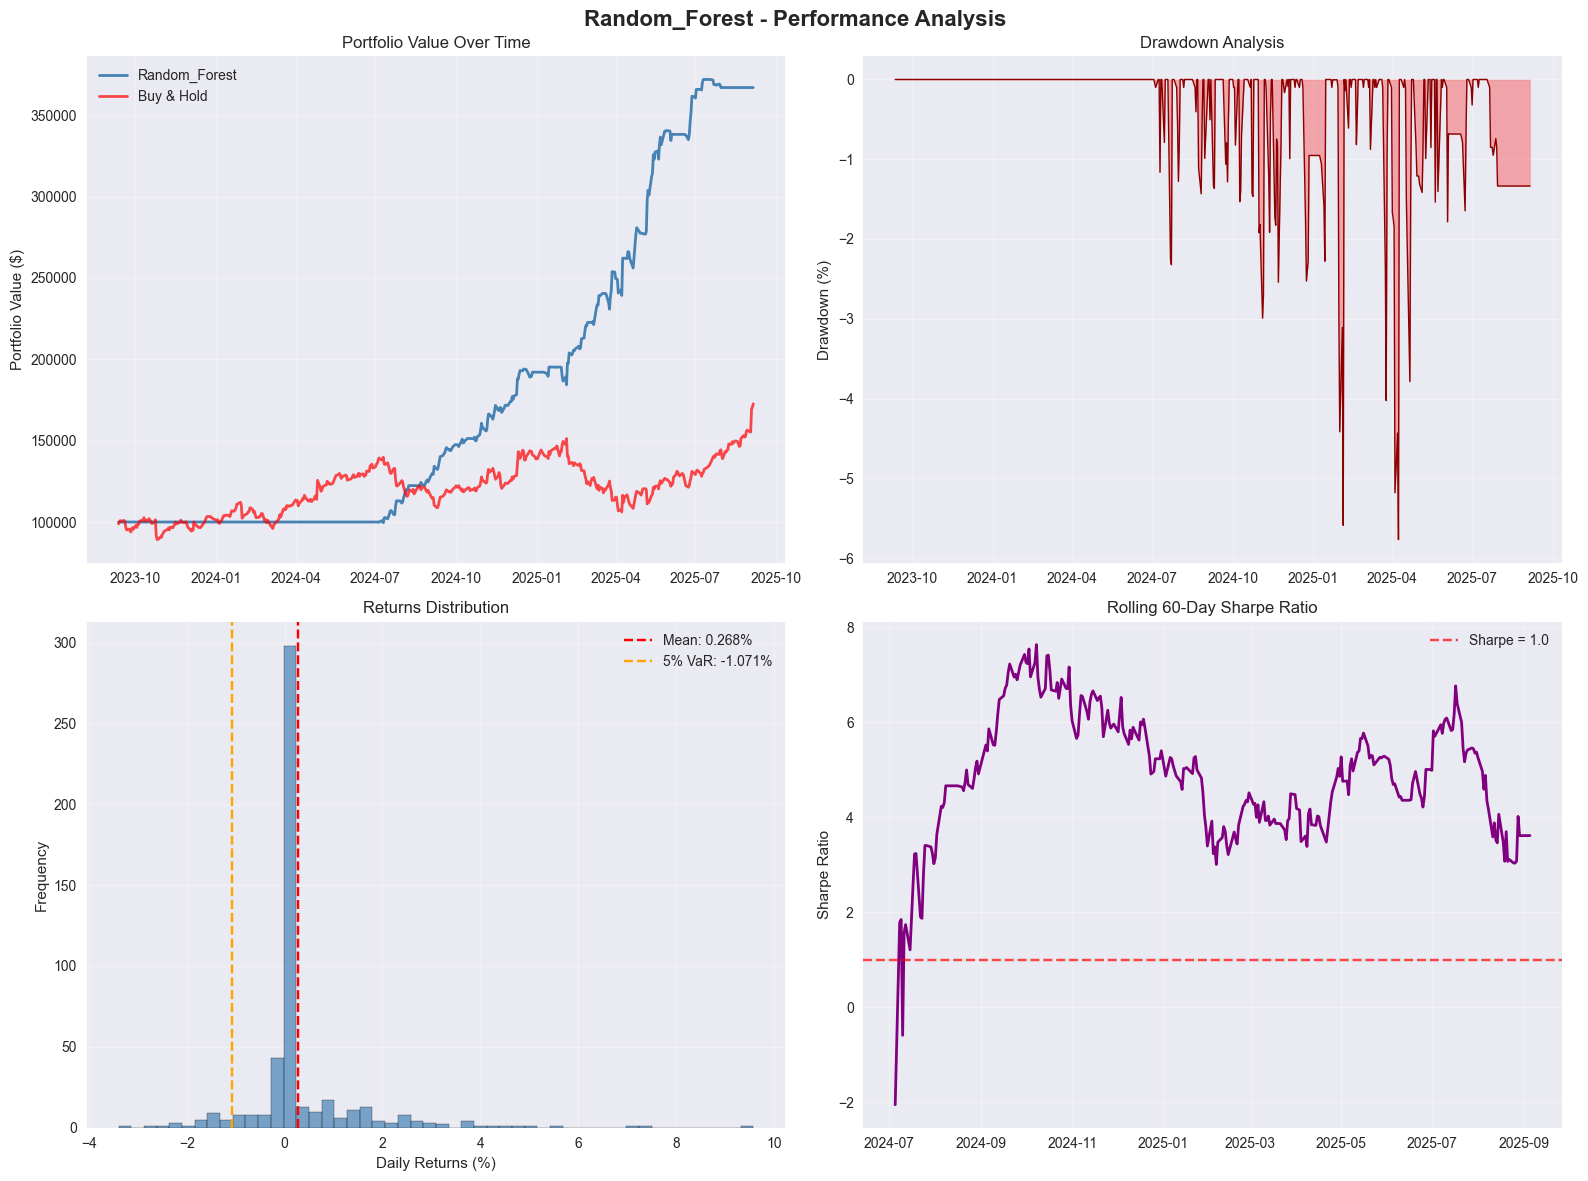

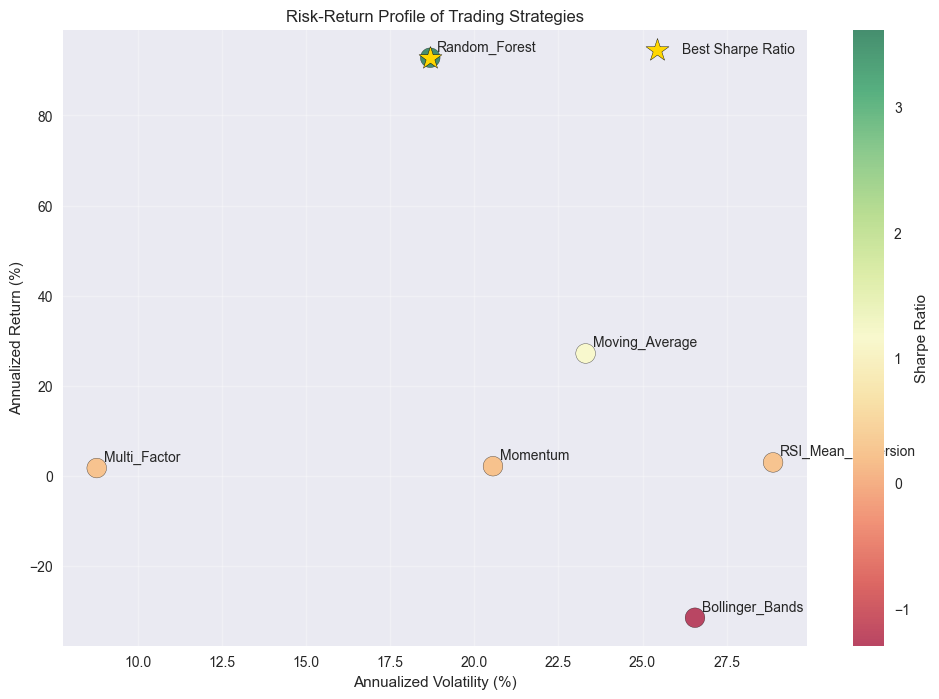


STEP 6: GENERATING TEAR SHEET

STRATEGY TEAR SHEET: Random_Forest

PERFORMANCE SUMMARY
Metric                    Value          
----------------------------------------
Total Return              267.03%
Annualized Return         92.83%
Sharpe Ratio              3.616
Win Rate                  55.2%
Total Trades              212

RISK ANALYSIS
Metric                    Value          
----------------------------------------
Volatility                18.69%
Maximum Drawdown          -5.77%

MARKET EXPOSURE
Metric                    Value          
----------------------------------------
Long Exposure             17.8%
Short Exposure            17.8%
Average Position Size     0.357

STEP 7: PORTFOLIO OPTIMIZATION
Optimal Portfolio Weights:
MSFT: 0.443
AMZN: 0.122
GOOGL: 0.435
Expected Return: 27.61%
Expected Volatility: 23.08%
Sharpe Ratio: 1.196

DEMO COMPLETE!
Key accomplishments:
• Analyzed 30 stocks
• Tested 6 trading strategies
• Successfully backtested 6 strategies
• Best strate

In [11]:
# Initialize components
data_manager = DataManager()
screener = StockScreener(data_manager)
strategies = TradingStrategies()
ml_strategies = MLTradingStrategies()
backtest_engine = BacktestEngine()
visualizer = PerformanceVisualizer()
optimizer = PortfolioOptimizer()

try:
    # Step 1: Stock Screening
    print("\nSTEP 1: STOCK SCREENING & SELECTION")
    screened_stocks, stock_data = screener.screen_stocks()
    
    if screened_stocks.empty or not stock_data:
        print("No stocks successfully screened. Using fallback data...")
        # Create sample data for demo
        dates = pd.date_range('2022-01-01', '2024-01-01', freq='D')
        np.random.seed(42)
        price_data = 100 * np.exp(np.random.randn(len(dates)).cumsum() * 0.01)
        
        sample_data = pd.DataFrame({
            'Open': price_data * (1 + np.random.randn(len(dates)) * 0.005),
            'High': price_data * (1 + abs(np.random.randn(len(dates))) * 0.01),
            'Low': price_data * (1 - abs(np.random.randn(len(dates))) * 0.01),
            'Close': price_data,
            'Volume': np.random.randint(1000000, 5000000, len(dates))
        }, index=dates)
        
        stock_data = {'DEMO_STOCK': sample_data}
        top_stock = 'DEMO_STOCK'
        print(f"Using demo stock: {top_stock}")
    else:
        top_stock = screened_stocks.iloc[0]['Ticker']
        print(f"Top 5 stocks by composite score:")
        print(screened_stocks[['Ticker', 'Composite_Score', 'Sharpe_Ratio']].head(5))
        print(f"\nSelected {top_stock} for detailed analysis")
    
    # Step 2: Strategy Testing
    print(f"\nSTEP 2: TESTING TRADING STRATEGIES ON {top_stock}")
    
    stock_data_enhanced = TechnicalIndicators.add_all_indicators(stock_data[top_stock])
    
    # Test strategies
    strategy_results = {}
    strategy_data_map = {}
    
    try:
        # Simple strategies
        print("Testing Moving Average strategy...")
        ma_result = strategies.moving_average_crossover(stock_data_enhanced)
        strategy_data_map['Moving_Average'] = ma_result
        
        print("Testing RSI strategy...")
        rsi_result = strategies.rsi_mean_reversion(stock_data_enhanced)
        strategy_data_map['RSI_Mean_Reversion'] = rsi_result
        
        print("Testing Bollinger Bands strategy...")
        bb_result = strategies.bollinger_bands_strategy(stock_data_enhanced)
        strategy_data_map['Bollinger_Bands'] = bb_result
        
        print("Testing Momentum strategy...")
        momentum_result = strategies.momentum_strategy(stock_data_enhanced)
        strategy_data_map['Momentum'] = momentum_result
        
        print("Testing Multi-Factor strategy...")
        multi_factor_result = strategies.multi_factor_strategy(stock_data_enhanced)
        strategy_data_map['Multi_Factor'] = multi_factor_result
        
        # ML strategies
        if len(stock_data_enhanced) > 200:  # Need sufficient data for ML
            try:
                print("Testing Random Forest strategy...")
                rf_result, rf_importance = ml_strategies.random_forest_strategy(stock_data_enhanced)
                strategy_data_map['Random_Forest'] = rf_result
                
                print("Top 3 ML features:", rf_importance.head(3)['Feature'].tolist())
            except Exception as e:
                print(f"ML strategy failed: {e}")
        
    except Exception as e:
        print(f"Strategy testing error: {e}")
    
    # Step 3: Backtesting
    print(f"\nSTEP 3: BACKTESTING STRATEGIES")
    
    for name, data in strategy_data_map.items():
        try:
            backtest_result, _ = backtest_engine.backtest_strategy(data, name)
            if backtest_result:
                strategy_results[name] = backtest_result
        except Exception as e:
            print(f"Backtesting failed for {name}: {e}")
    
    # Step 4: Performance Comparison
    if strategy_results:
        print(f"\nSTEP 4: STRATEGY PERFORMANCE COMPARISON")
        comparison_df = backtest_engine.compare_strategies()
        print("\nStrategy Performance Ranking:")
        print(comparison_df[['Total_Return_%', 'Sharpe_Ratio', 'Max_Drawdown']].round(3))
        
        # Best strategy analysis
        best_strategy_name = comparison_df.index[0]
        best_strategy_data = strategy_data_map[best_strategy_name]
        best_strategy_results = strategy_results[best_strategy_name]
        
        print(f"\nBest Strategy: {best_strategy_name}")
        print(f"Total Return: {best_strategy_results['Total_Return_%']:.2f}%")
        print(f"Sharpe Ratio: {best_strategy_results['Sharpe_Ratio']:.3f}")
        
        # Visualization
        print(f"\nSTEP 5: CREATING VISUALIZATIONS")
        visualizer.plot_strategy_performance(
            best_strategy_data, 
            best_strategy_name,
            stock_data[top_stock]
        )
        
        if len(strategy_results) > 1:
            visualizer.plot_risk_return_scatter(comparison_df)
        
        # Tear sheet
        print(f"\nSTEP 6: GENERATING TEAR SHEET")
        visualizer.create_tear_sheet(best_strategy_results, best_strategy_data)
        
    else:
        print("No successful strategy results to analyze")
    
    # Step 7: Portfolio Optimization (if multiple stocks available)
    if len(stock_data) >= 3:
        print(f"\nSTEP 7: PORTFOLIO OPTIMIZATION")
        
        returns_data = []
        tickers_for_portfolio = []
        
        for ticker, data in list(stock_data.items())[:5]:  # Limit to 5 stocks
            returns = data['Close'].pct_change().dropna()
            if len(returns) > 100:
                returns_data.append(returns)
                tickers_for_portfolio.append(ticker)
        
        if len(returns_data) >= 3:
            # Align returns
            returns_df = pd.concat(returns_data, axis=1, keys=tickers_for_portfolio)
            returns_df = returns_df.dropna()
            
            try:
                optimal_portfolio = optimizer.optimize_portfolio(returns_df, objective='sharpe')
                
                print("Optimal Portfolio Weights:")
                for i, ticker in enumerate(tickers_for_portfolio):
                    weight = optimal_portfolio['weights'][i]
                    if weight > 0.01:
                        print(f"{ticker}: {weight:.3f}")
                
                print(f"Expected Return: {optimal_portfolio['expected_return']:.2%}")
                print(f"Expected Volatility: {optimal_portfolio['volatility']:.2%}")
                print(f"Sharpe Ratio: {optimal_portfolio['sharpe_ratio']:.3f}")
                
            except Exception as e:
                print(f"Portfolio optimization failed: {e}")
    
    print(f"\nDEMO COMPLETE!")
    print("=" * 50)
    print("Key accomplishments:")
    print(f"• Analyzed {len(stock_data)} stocks")
    print(f"• Tested {len(strategy_data_map)} trading strategies") 
    print(f"• Successfully backtested {len(strategy_results)} strategies")
    if strategy_results:
        best_return = max([r['Total_Return_%'] for r in strategy_results.values()])
        print(f"• Best strategy return: {best_return:.2f}%")
    
    print({
        'stock_data': stock_data,
        'strategy_results': strategy_results,
        'comparison_df': comparison_df if strategy_results else None,
        'best_strategy': best_strategy_name if strategy_results else None
    })
    
except Exception as e:
    print(f"Demo failed with error: {e}")
    import traceback
    traceback.print_exc()